# Vector Search using Vespa.ai 

In this notebook we give an introduction to how to use 
[Vespa's approximate nearest neighbor search](https://docs.vespa.ai/en/approximate-nn-hnsw.html). 
In this notebook we'll be using the 
[Amazon Products dataset](http://jmcauley.ucsd.edu/data/amazon/links.html). 

We also demonstrate some of the [real world challenges](https://blog.vespa.ai/using-approximate-nearest-neighbor-search-in-real-world-applications/) with using approximate nearest neighbor search. 

- Combining the nearest neighbor search with filters 
- Real time indexing of vectors 
- True partial updates

Since we use the Amazon Products dataset in this notebook these are also relevant

- [Vespa.ai Use case Shopping Search](https://docs.vespa.ai/en/use-case-shopping.html)
- [E-commerce search and recommendation with Vespa.ai ](https://blog.vespa.ai/e-commerce-search-and-recommendation-with-vespaai/)

First let us install pyvespa which is a simple python api built on top of Vespa's native HTTP apis. 
The api is not meant as a production ready api but an api to explore features in Vespa and also for training ML models which can be deployed to Vespa for serving. 

In [ ]:
!pip3 install -U pyvespa

Let us download the demo data from the Amazon Products dataset, we use the *Amazon_Fashion* subset. 

This notebook was inspired by [this notebook](https://github.com/alexklibisz/elastiknn/blob/master/examples/tutorial-notebooks/multimodal-search-amazon-products.ipynb) so we'll reuse some of the utils from it to process the dataset. 

In [2]:
!wget -nc https://raw.githubusercontent.com/alexklibisz/elastiknn/master/examples/tutorial-notebooks/amazonutils.py
!wget -nc http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Amazon_Fashion.json.gz
!wget -nc http://snap.stanford.edu/data/amazon/productGraph/image_features/categoryFiles/image_features_Amazon_Fashion.b

File ‘amazonutils.py’ already there; not retrieving.

File ‘meta_Amazon_Fashion.json.gz’ already there; not retrieving.

File ‘image_features_Amazon_Fashion.b’ already there; not retrieving.



In [3]:
from amazonutils import *
from pprint import pprint

{'asin': 'B00019PGZY',
 'categories': [['Amazon Fashion']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/21RR8N9EE1L.jpg',
 'salesRank': {'Clothing': 3319656},
 'title': 'Infant Clothing - Kansas City Royals Onesie and Socks (Infant '
          'Medium)'}


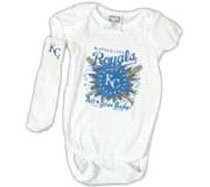

{'asin': 'B00019WSCI',
 'categories': [['Amazon Fashion']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/21V726MNF1L.jpg',
 'salesRank': {'Clothing': 3011822},
 'title': 'University of Kansas Shorts (Adult X-Large)'}


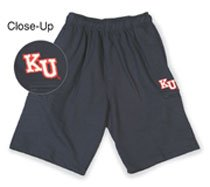

{'asin': 'B00019WL1G',
 'categories': [['Amazon Fashion']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/21CK37JPSQL.jpg',
 'salesRank': {'Clothing': 2810922},
 'title': 'Hanshin Tigers Japan Baseball League Cap (6 7/8)'}


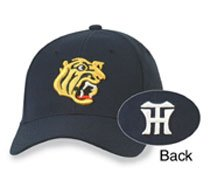

{'asin': 'B00019VW7U',
 'categories': [['Amazon Fashion']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/31A88SP4YFL.jpg',
 'salesRank': {'Clothing': 1707519},
 'title': 'Brooklyn Dodgers Jackie Robinson #42 Royal Blue T-Shirt (Adult '
          'XX-Large)'}


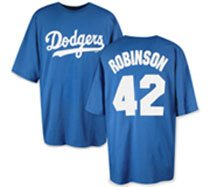

In [4]:
for p in islice(iter_products('meta_Amazon_Fashion.json.gz'), 200,204):
  pprint(p)
  display(Image(p['imUrl'], width=128, height=128))

A Vespa instance is described by a [Vespa application package](https://docs.vespa.ai/en/cloudconfig/application-packages.html). Let us create an application called product and define our [document schema](https://docs.vespa.ai/en/schemas.html)

In [28]:
from vespa.package import ApplicationPackage
app_package = ApplicationPackage(name = "product")

In [29]:
from vespa.package import Field, HNSW
app_package.schema.add_fields(        
    Field(name = "asin", type = "string", indexing = ["attribute", "summary"]),
    Field(name = "title", type = "string", indexing = ["index", "summary"], index = "enable-bm25"),
    Field(name = "description", type = "string", indexing = ["index", "summary"], index = "enable-bm25"),
    Field(name = "price", type = "float", indexing = ["attribute", "summary"]),
    Field(name = "salesRank", type = "weightedset<string>", indexing = ["summary","attribute"]),
    Field(name = "imUrl", type = "string", indexing = ["summary"])
)

We define a fieldset which is a way to combine matching over multiple fields. We chose to only match queries over the *title* and *description* field. 

In [30]:
from vespa.package import FieldSet
app_package.schema.add_field_set(
    FieldSet(name = "default", fields = ["title", "description"])
)

Then define a simple ranking function which uses a linear combination of the [bm25](https://docs.vespa.ai/en/reference/bm25.html) text ranking feature over our two free text string fields. 

In [31]:
from vespa.package import RankProfile
app_package.schema.add_rank_profile(
    RankProfile(
        name = "bm25", 
        first_phase = "0.9*bm25(title) + 0.2*bm25(description)")
)

So let us deploy this application. We use docker in this example. See also [Vespa quick start](https://docs.vespa.ai/en/vespa-quick-start.html)

In [12]:
from vespa.package import VespaDocker
vespa_docker = VespaDocker(port=8080)

app = vespa_docker.deploy(
    application_package = app_package,
    disk_folder="/Users/bergum/demo/product_search" # include the desired absolute path here
)

Waiting for configuration server.
Waiting for configuration server.
Waiting for configuration server.
Waiting for configuration server.
Waiting for configuration server.
Waiting for configuration server.
Waiting for configuration server.
Waiting for application status.
Waiting for application status.


In [13]:
app.deployment_message

["Uploading application '/app/application' using http://localhost:19071/application/v2/tenant/default/session",
 "Session 2 for tenant 'default' created.",
 'Preparing session 2 using http://localhost:19071/application/v2/tenant/default/session/2/prepared',
 "WARNING: Host named 'product' may not receive any config since it is not a canonical hostname. Disregard this warning when testing in a Docker container.",
 "Session 2 for tenant 'default' prepared.",
 'Activating session 2 using http://localhost:19071/application/v2/tenant/default/session/2/active',
 "Session 2 for tenant 'default' activated.",
 'Checksum:   9d3c04b6ab6c90b64d9d3377b03d5423',
 'Timestamp:  1613385068359',
 'Generation: 2',
 '']

Pyvespa does expose a feed api, but in this notebook we expose the raw [Vespa HTTP feed api](https://docs.vespa.ai/en/document-v1-api-guide.html). 

The HTTP document api is synchronous and the operation is visible in search when acked with a response code 200. 

In [17]:
import requests 
session = requests.Session()

def index_document(product):
    asin = product['asin']
    doc = {
        "fields": {
            "asin": asin,
            "title": product.get("title",None),
            "description": product.get('description',None),
            "price": product.get("price",None),
            "imUrl": product.get("imUrl",None),
            "salesRank": product.get("salesRank",None)     
        }
    }
    resource = "http://localhost:8080/document/v1/demo/product/docid/{}".format(asin)
    request_response = session.post(resource,json=doc)
    request_response.raise_for_status()

In [18]:
from tqdm import tqdm
for product in tqdm(iter_products("meta_Amazon_Fashion.json.gz")):
    index_document(product)

24145it [05:12, 77.36it/s]


So we have our index ready, let us define a simple routine to display the search result

In [72]:
def display_hits(res, ranking):
    time = 1000*res['timing']['searchtime'] #convert to ms
    totalCount = res['root']['fields']['totalCount']
    print("Found {} hits in {:.2f} ms.".format(totalCount,time))
    print("Showing top {}, ranked by {}".format(len(res['root']['children']),ranking))
    print("")
    for hit in res['root']['children']:
        fields = hit['fields']
        print("{}".format(fields.get('title', None)))
        display(Image(fields.get("imUrl"), width=128, height=128))  
        print("documentid: {}".format(fields.get('documentid')))
        if 'inventory' in fields:
            print("Inventory: {}".format(fields.get('inventory')))
        print("asin: {}".format(fields.get('asin')))
        print("price: {}".format(fields.get('price',None)))
        print("priceRank: {}".format(fields.get('priceRank',None)))  
        print("relevance score: {:.2f}".format(hit.get('relevance')))
        print("")


# Query our data

We use the [Vespa HTTP Search API](https://docs.vespa.ai/en/query-api.html#http)

We assume there is a user query 'mens wrist watch' which we use as input to the 
[YQL](https://docs.vespa.ai/en/query-language.html) query language. Vespa allows combining the structured application logic expressed by YQL with a user query language called [Vespa simple query language](https://docs.vespa.ai/en/reference/simple-query-language-reference.html) 


Found 3285 hits in 15.00 ms.
Showing top 2, ranked by bm25

Geekbuying 814 Analog Alloy Quartz Men's Wrist Watch - Black (White)


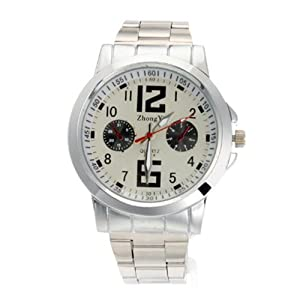

documentid: id:demo:product::B00GLP1GTW
asin: B00GLP1GTW
price: 8.99
priceRank: None
relevance score: 10.27

Popular Quality Brand New Fashion Mens Boy Leatheroid Quartz Wrist Watch Watches


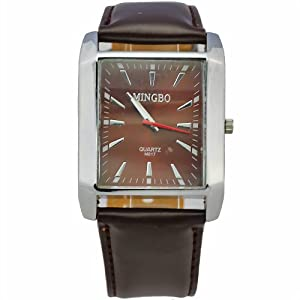

documentid: id:demo:product::B009EJATDQ
asin: B009EJATDQ
price: None
priceRank: None
relevance score: 9.67



In [76]:
query = {
    'yql': 'select documentid, asin,title,imUrl,price from sources * where userQuery();',
    'query': 'mens wrist watch',
    'ranking': 'bm25',
    'type': 'any',
    'presentation.timing': True,
    'hits': 2
}
display_hits(app.query(body=query).json, "bm25")

## Similarity Search using image vector data
Now we have basic search functionality up and running, but the Amazon Product dataset also inclues image features which we can also index in Vespa and use approximate nearest neighbor search to search efficiently. Let us load the image feature data. We use 256 dimensions. 

In [22]:
vectors = []
reduced = iter_vectors_reduced("image_features_Amazon_Fashion.b", 256, 1000)
for asin,v in tqdm(reduced("image_features_Amazon_Fashion.b")):
    vectors.append((asin,v))

22929it [00:07, 2891.01it/s]


We need to re-configure our application to add the vector field. We also define a HNSW index for it and using angular as our distance metric. We also need to define the input query vector in the application package

In [32]:
from vespa.package import HNSW
app_package.schema.add_fields(
    Field(name = "image_vector", 
          type = "tensor<float>(x[256])", 
          indexing = ["attribute","index"],
          ann=HNSW(
            distance_metric="angular",
            max_links_per_node=16,
            neighbors_to_explore_at_insert=200)
         )
)
from vespa.package import QueryTypeField
app_package.query_profile_type.add_fields(
    QueryTypeField(name="ranking.features.query(query_image_vector)", type="tensor<float>(x[256])")
)

We also need to define a ranking profile on how we want to score our documents. We use the built in closeness ranking feature. Note that it's also possible to retrieve results using approximate nearest neighbor search operator and use the first phase ranking function as a re-ranking stage (e.g by sales popularity etc). 


In [33]:
app_package.schema.add_rank_profile(
    RankProfile(
        name = "vector_similarity", 
        first_phase = "closeness(field,image_vector)")
)

Now, we need to re-deploy our application package to make the changes effective

In [34]:
app_package

ApplicationPackage('product', Schema('product', Document([Field('asin', 'string', ['attribute', 'summary'], None, None, None), Field('title', 'string', ['index', 'summary'], 'enable-bm25', None, None), Field('description', 'string', ['index', 'summary'], 'enable-bm25', None, None), Field('price', 'float', ['attribute', 'summary'], None, None, None), Field('salesRank', 'weightedset<string>', ['summary', 'attribute'], None, None, None), Field('imUrl', 'string', ['summary'], None, None, None), Field('image_vector', 'tensor<float>(x[256])', ['attribute', 'index'], None, None, HNSW('angular', 16, 200))]), [FieldSet('default', ['title', 'description'])], [RankProfile('bm25', '0.9*bm25(title) + 0.2*bm25(description)', None, None, None, None, None), RankProfile('vector_similarity', 'closeness(field,image_vector)', None, None, None, None, None)], []), QueryProfile(None), QueryProfileType([QueryTypeField('ranking.features.query(query_image_vector)', 'tensor<float>(x[256])')]))

In [35]:
app = vespa_docker.deploy(
    application_package = app_package,
    disk_folder="/Users/bergum/demo/product_search" # include the desired absolute path here
)

In [36]:
app.deployment_message

["Uploading application '/app/application' using http://localhost:19071/application/v2/tenant/default/session",
 "Session 4 for tenant 'default' created.",
 'Preparing session 4 using http://localhost:19071/application/v2/tenant/default/session/4/prepared',
 "WARNING: Host named 'product' may not receive any config since it is not a canonical hostname. Disregard this warning when testing in a Docker container.",
 "Session 4 for tenant 'default' prepared.",
 'Activating session 4 using http://localhost:19071/application/v2/tenant/default/session/4/active',
 "Session 4 for tenant 'default' activated.",
 'Checksum:   7cc4404fe547b8bd84f1a579e877dc15',
 'Timestamp:  1613385782154',
 'Generation: 4',
 '']

Let us index the vectors. We update the index by running update operations, adding the vectors using real time updates of the existing documents. 

In [38]:
for asin,vector in tqdm(vectors):
    update_doc = {
        "fields":  {
            "image_vector": {
                "assign": {
                    "values": vector
                }
            }
        }
    }
    url = "http://localhost:8080/document/v1/demo/product/docid/{}".format(asin)
    response = session.put(url, json=update_doc)

100%|██████████| 22929/22929 [05:08<00:00, 74.25it/s]


Let us repeat the query from above

Found 3285 hits in 9.00 ms.
Showing top 1, ranked by bm25

Geekbuying 814 Analog Alloy Quartz Men's Wrist Watch - Black (White)


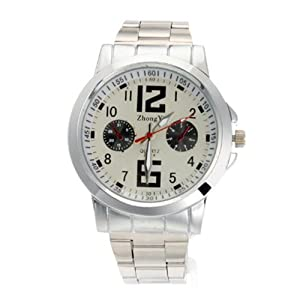

documentid: id:demo:product::B00GLP1GTW
asin: B00GLP1GTW
price: 8.99
priceRank: None
relevance score: 10.27



In [77]:
query = {
    'yql': 'select documentid, asin,title,imUrl,price from sources * where userQuery();',
    'query': 'mens wrist watch',
    'ranking': 'bm25',
    'type': 'any',
    'presentation.timing': True,
    'hits': 1
}
display_hits(app.query(body=query).json, "bm25")

We now want to get similar products using the image feature data and we do so by first fetching the 
vector of the product we want to find similar products for and use this vector as input to the nearest neighbor search operator of Vespa. First we define a simple get vector utility to fetch the vector of a given product *asin*. 

In [42]:
def get_vector(asin):
    resource = "http://localhost:8080/document/v1/demo/product/docid/{}".format(asin)
    response = session.get(resource)
    response.raise_for_status()
    document = response.json()
    
    cells = document['fields']['image_vector']['cells']
    vector = {}
    for i,cell in enumerate(cells):
        v = cell['value']
        adress = cell['address']['x']
        vector[int(adress)] = v
    values = []
    for i in range(0,256):
        values.append(vector[i])
    return values

Let us search for similar images using **exact** nearest neighbor search. We ask for 3 most similar to the product image with asin id **B00GLP1GTW**

Found 46 hits in 88.00 ms.
Showing top 3, ranked by vector_similarity

Geekbuying 814 Analog Alloy Quartz Men's Wrist Watch - Black (White)


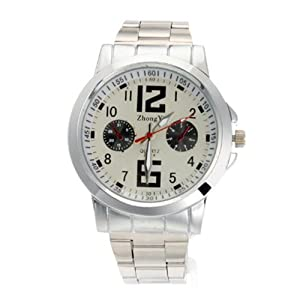

documentid: None
asin: B00GLP1GTW
price: 8.99
priceRank: None
relevance score: 1.00

Avalon EZC Unisex Low-Vision Silver-Tone Flex Bracelet One-Button Talking Watch, # 2609-1B


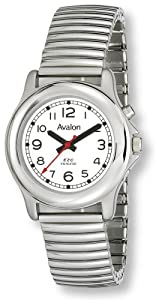

documentid: None
asin: B000M9GQ0M
price: 44.95
priceRank: None
relevance score: 0.63

White Rubber Strap Digital Watch


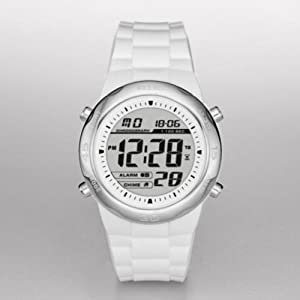

documentid: None
asin: B003ZYXF1Y
price: None
priceRank: None
relevance score: 0.62



In [78]:
query = {
    'yql': 'select asin,title,imUrl,description,price from sources * where \
    ([{"targetHits":3,"approximate":false}]nearestNeighbor(image_vector,query_image_vector));',
    'ranking': 'vector_similarity',
    'hits': 3, 
    'presentation.timing': True,
    'ranking.features.query(query_image_vector)': get_vector('B00GLP1GTW')
}
display_hits(app.query(body=query).json, "vector_similarity")

Let us repeat the above, this time using approximate version. When there is a HNSW index on the tensor the default behavior is to use approximate:true so we remove the approximation flag. 

Found 3 hits in 10.00 ms.
Showing top 3, ranked by vector_similarity

Geekbuying 814 Analog Alloy Quartz Men's Wrist Watch - Black (White)


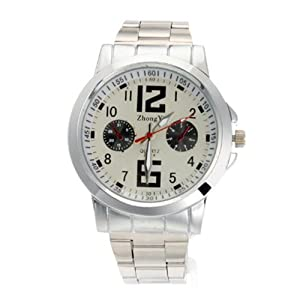

documentid: None
asin: B00GLP1GTW
price: 8.99
priceRank: None
relevance score: 1.00

Avalon EZC Unisex Low-Vision Silver-Tone Flex Bracelet One-Button Talking Watch, # 2609-1B


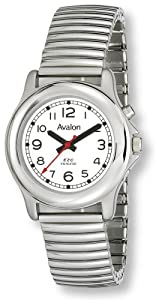

documentid: None
asin: B000M9GQ0M
price: 44.95
priceRank: None
relevance score: 0.63

White Rubber Strap Digital Watch


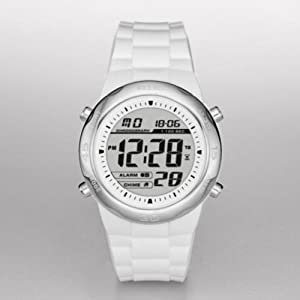

documentid: None
asin: B003ZYXF1Y
price: None
priceRank: None
relevance score: 0.62



In [79]:
query = {
    'yql': 'select asin,title,imUrl,description,price from sources * where \
    ([{"targetHits":3}]nearestNeighbor(image_vector,query_image_vector));',
    'ranking': 'vector_similarity',
    'hits': 3, 
    'presentation.timing': True,
    'ranking.features.query(query_image_vector)': get_vector('B00GLP1GTW')
}
display_hits(app.query(body=query).json, "vector_similarity")

Hit number 1 is the same product that we used as input and the closeness score is 1.0.  Let us remove it by adding a filter for asin = B00GLP1GTW

Found 3 hits in 9.00 ms.
Showing top 3, ranked by vector_similarity

Avalon EZC Unisex Low-Vision Silver-Tone Flex Bracelet One-Button Talking Watch, # 2609-1B


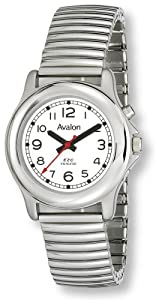

documentid: id:demo:product::B000M9GQ0M
asin: B000M9GQ0M
price: 44.95
priceRank: None
relevance score: 0.63

White Rubber Strap Digital Watch


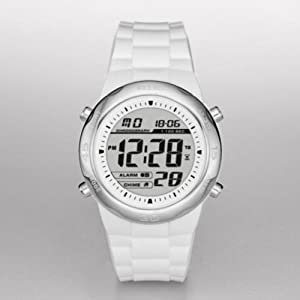

documentid: id:demo:product::B003ZYXF1Y
asin: B003ZYXF1Y
price: None
priceRank: None
relevance score: 0.62

Suunto Men's D6i W/ TRANSMITTER Athletic Watches


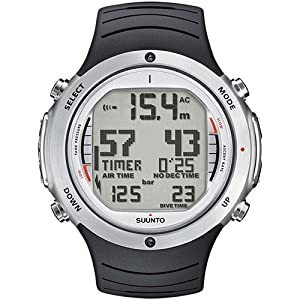

documentid: id:demo:product::B007963FS2
asin: B007963FS2
price: None
priceRank: None
relevance score: 0.61



In [80]:
query = {
    'yql': 'select documentid, asin,title,imUrl,description,price from sources * where \
    ([{"targetHits":3}]nearestNeighbor(image_vector,query_image_vector)) and \
    !(asin contains "B00GLP1GTW");',
    'ranking': 'vector_similarity',
    'hits': 3, 
    'presentation.timing': True,
    'ranking.features.query(query_image_vector)': get_vector('B00GLP1GTW')
}
display_hits(app.query(body=query).json, "vector_similarity")

That is better. The original product is removed from the list of similar products. 

But maybe we should find something a bit more expensive? Let us add a price filter, only display items  which costs more than 100$. We still ask for the 3 nearest neighbors. 

Found 19 hits in 11.00 ms.
Showing top 3, ranked by vector_similarity

Hamilton Men's H64455133 Khaki King II Black Dial Watch


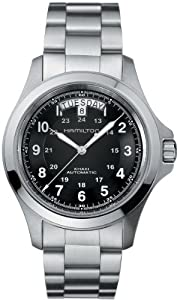

documentid: id:demo:product::B001F7MIY8
asin: B001F7MIY8
price: 400.0
priceRank: None
relevance score: 0.60

Wenger Men's 62800 Knife Combo Watch Set


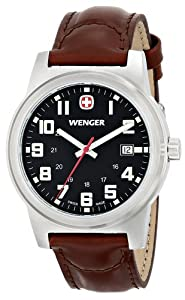

documentid: id:demo:product::B00CM1RPW6
asin: B00CM1RPW6
price: 150.71
priceRank: None
relevance score: 0.59

Deporte Ardmore Mens Watch


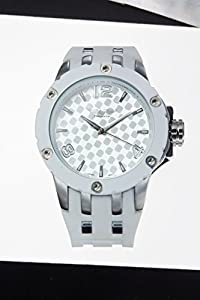

documentid: id:demo:product::B00KY992QU
asin: B00KY992QU
price: 789.0
priceRank: None
relevance score: 0.59



In [81]:
query = {
    'yql': 'select documentid, asin,title,imUrl,description,price from sources * where \
    ([{"targetHits":3}]nearestNeighbor(image_vector,query_image_vector)) and \
    !(asin contains "B00GLP1GTW") and \
    price > 100;',
    'ranking': 'vector_similarity',
    'hits': 3, 
    'presentation.timing': True,
    'ranking.features.query(query_image_vector)': get_vector('B00GLP1GTW')
}
display_hits(app.query(body=query).json, "vector_similarity")

# Real time updates 

Now, we will add a new field which we call inventory and which keeps track of the inventory status of products. We want to ensure that the products we display have a positive inventory status. 


In [64]:
app_package.schema.add_fields(        
    Field(name = "inventory", type = "int", indexing = ["attribute", "summary"])
)

In [65]:
app = vespa_docker.deploy(
    application_package = app_package,
    disk_folder="/Users/bergum/demo/product_search" # include the desired absolute path here
)

We iterate over our products and assign a random inventory count. We use partial update to do this. Vespa can handle up to 50K updates of integer fields per node and the partial update is performed in place so the document is not re-indexed in any way.

In [69]:
import random
for product in tqdm(iter_products("meta_Amazon_Fashion.json.gz")):
    asin = product['asin']
    update_doc = {
        "fields":  {
            "inventory": {
                "assign": random.randint(0,10)
            }
        }
    }
    url = "http://localhost:8080/document/v1/demo/product/docid/{}".format(asin)
    response = session.put(url, json=update_doc)

24145it [05:11, 77.54it/s] 


Let us repeat our query for expensive similar products using image similarity, now we also display the inventory status

Found 19 hits in 11.00 ms.
Showing top 3, ranked by vector_similarity

Hamilton Men's H64455133 Khaki King II Black Dial Watch


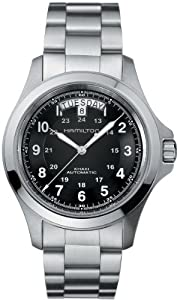

documentid: id:demo:product::B001F7MIY8
Inventory: 4
asin: B001F7MIY8
price: 400.0
priceRank: None
relevance score: 0.60

Wenger Men's 62800 Knife Combo Watch Set


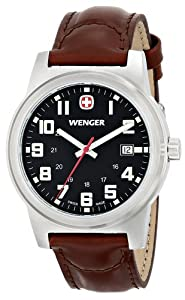

documentid: id:demo:product::B00CM1RPW6
Inventory: 4
asin: B00CM1RPW6
price: 150.71
priceRank: None
relevance score: 0.59

Deporte Ardmore Mens Watch


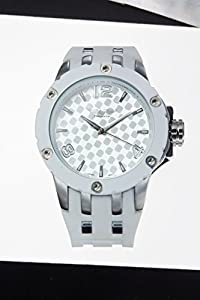

documentid: id:demo:product::B00KY992QU
Inventory: 0
asin: B00KY992QU
price: 789.0
priceRank: None
relevance score: 0.59



In [82]:
query = {
    'yql': 'select documentid, inventory, asin,title,imUrl,description,price from sources * where \
    ([{"targetHits":3}]nearestNeighbor(image_vector,query_image_vector)) and \
    !(asin contains "B00GLP1GTW") and \
    price > 100;',
    'ranking': 'vector_similarity',
    'hits': 3, 
    'presentation.timing': True,
    'ranking.features.query(query_image_vector)': get_vector('B00GLP1GTW')
}
display_hits(app.query(body=query).json, "vector_similarity")

So as we can see the B00KY992QU has inventory status 0, so let us add an inventory filter to our search and repeat the query. 

Found 17 hits in 13.00 ms.
Showing top 3, ranked by vector_similarity

Hamilton Men's H64455133 Khaki King II Black Dial Watch


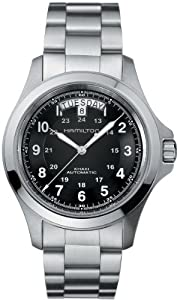

documentid: id:demo:product::B001F7MIY8
Inventory: 4
asin: B001F7MIY8
price: 400.0
priceRank: None
relevance score: 0.60

Wenger Men's 62800 Knife Combo Watch Set


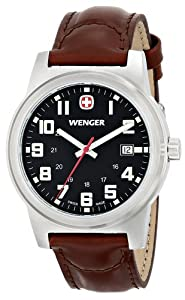

documentid: id:demo:product::B00CM1RPW6
Inventory: 4
asin: B00CM1RPW6
price: 150.71
priceRank: None
relevance score: 0.59

Seiko Quartz Stainless Steel SXDB37P1


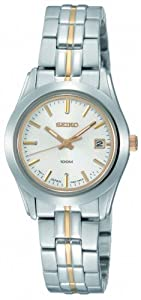

documentid: id:demo:product::B001TDOILY
Inventory: 7
asin: B001TDOILY
price: 216.9
priceRank: None
relevance score: 0.58



In [83]:
query = {
    'yql': 'select documentid, inventory, asin,title,imUrl,description,price from sources * where \
    ([{"targetHits":3}]nearestNeighbor(image_vector,query_image_vector)) and \
    !(asin contains "B00GLP1GTW") and \
     price > 100 and inventory > 0;',
    'ranking': 'vector_similarity',
    'hits': 3, 
    'presentation.timing': True,
    'ranking.features.query(query_image_vector)': get_vector('B00GLP1GTW')
}
display_hits(app.query(body=query).json, "vector_similarity")

That's better. Now all related items have inventory status > 0 and price > 100$. 


# Summary

In this notebook we have demonstrated Vespa's nearest neighbor search and approximate nearest neighbor search and how Vespa allows combining nearest neighbor search with filters. To learn more see [https://vespa.ai](https://vespa.ai)